# Experiments with the CPAC_N7_09_15_20 dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re
import warnings
import statistics

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

from IPython.display import display, Markdown

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC_N7_09_15_20/CPAC10S_N7_09_15_20.csv")
df_orig.describe()

,M_Trial_Num,M_Mass,M_Mass_to_L5S1,M_sub_task_indices,M_sub_task_num,M_include_overall,M_Index,M_Sub,M_sub_task_num_overall,M_Index_overall,...,RWEO_03_04_00_00_INSOLE_LY_AP_threshF50_mm,RWEO_01_00_00_00_INSOLE_RFORCE_threshF50_N,RWEO_01_02_00_00_INSOLE_RX_ML_threshF50_mm,RWEO_01_02_00_00_INSOLE_RY_AP_threshF50_mm,RWEF_03_00_00_00_INSOLE_LFORCE_threshF50_BW,RWEF_03_04_00_00_INSOLE_LX_ML_threshF50_BH,RWEF_03_04_00_00_INSOLE_LY_AP_threshF50_BH,RWEF_01_00_00_00_INSOLE_RFORCE_threshF50_BW,RWEF_01_02_00_00_INSOLE_RX_ML_threshF50_BH,RWEF_01_02_00_00_INSOLE_RY_AP_threshF50_BH
count,1.366326e+06,1.366326e+06,1.040590e+06,1.366326e+06,1.366326e+06,1.366326e+06,1.366326e+06,1.366326e+06,1.366326e+06,1.366326e+06,...,1.178199e+06,1.363161e+06,1.223529e+06,1.223529e+06,1.363161e+06,1.178199e+06,1.178199e+06,1.363161e+06,1.223529e+06,1.223529e+06
mean,6.907848e+01,1.059573e+01,3.126288e-01,2.912306e+02,5.583528e+00,8.073256e-01,2.716548e+03,3.855173e+00,2.384674e+02,8.848465e+04,...,1.216852e+02,3.945501e+02,4.903974e+01,1.334307e+02,6.155901e-01,2.797499e-02,6.701906e-02,6.472693e-01,2.697077e-02,7.335476e-02
std,2.360488e+01,5.886671e+00,1.644402e-01,3.589143e+02,4.895601e+00,3.943996e-01,2.598654e+03,1.998726e+00,1.246093e+02,6.576090e+04,...,5.277402e+01,2.768346e+02,8.572305e+00,4.881799e+01,5.533887e-01,5.171558e-03,2.932588e-02,5.626440e-01,4.770854e-03,2.717074e-02
min,1.000000e+00,0.000000e+00,5.026420e-02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.950165e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.900000e+01,5.000000e+00,1.602113e-01,1.160000e+02,1.000000e+00,1.000000e+00,5.950000e+02,2.000000e+00,1.280000e+02,2.824900e+04,...,7.683000e+01,1.603150e+02,4.502000e+01,9.433000e+01,2.381477e-01,2.584712e-02,4.235504e-02,2.565648e-01,2.446361e-02,5.173437e-02
50%,7.900000e+01,1.000000e+01,2.776286e-01,2.350000e+02,4.000000e+00,1.000000e+00,1.853500e+03,4.000000e+00,2.500000e+02,8.517900e+04,...,1.140600e+02,3.650450e+02,5.061000e+01,1.317400e+02,5.112327e-01,2.904687e-02,6.220556e-02,5.398100e-01,2.793333e-02,7.169364e-02
75%,8.700000e+01,1.500000e+01,4.583651e-01,3.790000e+02,8.000000e+00,1.000000e+00,4.185000e+03,6.000000e+00,3.430000e+02,1.421090e+05,...,1.667400e+02,5.945630e+02,5.464000e+01,1.751000e+02,8.329281e-01,3.126012e-02,9.096354e-02,8.659949e-01,2.999444e-02,9.523958e-02
max,9.600000e+01,2.300000e+01,7.376715e-01,7.238000e+03,2.200000e+01,1.000000e+00,1.411900e+04,7.000000e+00,4.570000e+02,2.370080e+05,...,2.477000e+02,1.558065e+03,7.442000e+01,2.508700e+02,5.463242e+00,4.218023e-02,1.440116e-01,5.719531e+00,4.326744e-02,1.458547e-01


## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")    

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [4]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})")
print(f"Number of subjects: {len(df['M_Sub'].unique())}")

Number of samples: 1103070 (before clean-up: 1366326)
Number of trials: 162 (before clean-up: 162)
Number of subjects: 7


## Predictor configurations (recipes)

In [6]:
def predictor_short_name(predictor):
    return predictor[17:]

def predictor_sensor_number(predictor):
    return int(predictor[5:7])

def filter_predictors(all_predictors, patterns):
    if isinstance(patterns, str):
        patterns = (patterns,)
        
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
    "Recipe 1: Simulated Wearable - All Regular": 
        filter_predictors(df.columns, "SWRF"),
    
    "Recipe 2: Simulated Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("SWRF", "SWEF")),
    
    "Recipe 3: Real Wearable - All Regular": 
        filter_predictors(df.columns, "RWRF"),
    
    "Recipe 4: Real Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("RWRF", "RWEF")),
    
    "Recipe 5: Real Wearable - Insole Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00")
        ),
    
    "Recipe 6: Real Wearable - Trunk Orientatoin Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("12_00_00_00",)
        ),
    
    "Recipe 7: Real Wearable - Insole & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00")
        ),
    
    "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00",
             "05_06_00_00", "05_09_00_00", "06_00_00_00", "09_00_00_00", "05_12_00_00", "05_06_01_03", "05_09_01_03")
        ),
    
    "Recipe 9: SW trunk angle + SW force":
            filter_predictors(df.columns, ("TRUNK_ANGLE_VL_X_sag", "GRF_RightFoot_Z_BW", "GRF_LeftFoot_Z_BW")),
    
    "Recipe 10: RW trunk angle + RW force":
            filter_predictors(df.columns, ("L5_orientation_eY_sag", "INSOLE_RFORCE_BW", "INSOLE_LFORCE_BW")),

    "Recipe 11: SW trunk angle + RW force":
            filter_predictors(df.columns, ("TRUNK_ANGLE_VL_X_sag", "INSOLE_RFORCE_BW", "INSOLE_LFORCE_BW")),

    "Recipe 12: RW trunk angle + SW force":
            filter_predictors(df.columns, ("L5_orientation_eY_sag", "GRF_RightFoot_Z_BW", "GRF_LeftFoot_Z_BW")),
    
    "Recipe 13: Simulated Wearable - Trunk Orientatoin Only":
        filter_predictors(
            filter_predictors(df.columns, ("SWRF", "SWEF")),
            ("05_12_00_00",)
        ),
                              
    "Recipe 14: Simulated Wearable - Insole & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("SWRF", "SWEF")),
            ("05_12_00_00", "01_00_00_00", "03_00_00_00", "05_12_01_03", "01_02_00_00", "03_04_00_00", "01_03_00_00")
        ),
    
    "Recipe 15: Simulated Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("SWRF", "SWEF")),
            ("05_12_00_00", "01_00_00_00", "03_00_00_00", 
             "05_12_01_03", "05_06_00_00", "05_09_00_00", "05_06_01_03", "05_09_01_03", 
             "01_02_00_00", "03_04_00_00", "01_03_00_00")
        ),
                              
                              
    
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")

Recipe 1: Simulated Wearable - All Regular
	Predictors: 75, Sensors: 10

Recipe 2: Simulated Wearable - All Regular & Exploratory
	Predictors: 104, Sensors: 10

Recipe 3: Real Wearable - All Regular
	Predictors: 166, Sensors: 10

Recipe 4: Real Wearable - All Regular & Exploratory
	Predictors: 201, Sensors: 10

Recipe 5: Real Wearable - Insole Only
	Predictors: 17, Sensors: 2

Recipe 6: Real Wearable - Trunk Orientatoin Only
	Predictors: 56, Sensors: 1

Recipe 7: Real Wearable - Insole & Trunk Orientation
	Predictors: 77, Sensors: 3

Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
	Predictors: 133, Sensors: 6

Recipe 9: SW trunk angle + SW force
	Predictors: 5, Sensors: 3

Recipe 10: RW trunk angle + RW force
	Predictors: 3, Sensors: 3

Recipe 11: SW trunk angle + RW force
	Predictors: 5, Sensors: 3

Recipe 12: RW trunk angle + SW force
	Predictors: 3, Sensors: 3

Recipe 13: Simulated Wearable - Trunk Orientatoin Only
	Predictors: 14, Sensors: 1

Recipe 14: Simulated 

## Train/Test configurations


Instead of custom train/test selections, we are using subject-based cross validation.

## Train and evaluate boosted tree models

In [7]:
def evaluate(desc, feature_names, target_name, show_plot=False, show_importance=False):
    X, y, groups = df[feature_names], df[target_name], df["M_Sub"]
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor())
    ])
    
    logo = model_selection.LeaveOneGroupOut()
    
    r2 = model_selection.cross_val_score(model, X, y, cv=logo, groups=groups).mean()
    y_pred = model_selection.cross_val_predict(model, X, y, cv=logo, groups=groups)
    
    
    display(
        Markdown(
            "---\n"
            f"**Target**: {desc['target']}  \n"
            f"**Features**: {desc['feature_set']}  \n"
            f"**R2={r2:.3f}**"
        )
    )
    
    if show_plot:
        ax = sns.jointplot(y, y_pred, alpha=0.1, s=1.0, color=desc["color"])
        ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title("Predictions")

        summary = r"$\mathrm{R}^2=%.3f$" % (r2,)

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()
        
    if show_importance:
        for imp_train_idx, imp_test_idx in logo.split(X, y, groups):
            model.fit(X.iloc[imp_train_idx], y.iloc[imp_train_idx])
            feature_importances = inspection.permutation_importance(model, 
                                           X.iloc[imp_test_idx], 
                                           y.iloc[imp_test_idx], 
                                           n_repeats=5, n_jobs=-1)
            # TODO: cheating: evaluate this for the first CV split
            break
        top_idxs = feature_importances.importances_mean.argsort()[::-1][:6]
        fig, ax = plt.subplots()
#         ax.boxplot(feature_importances.importances[top_idxs].T,
#                vert=False, labels=[predictor_short_name(X_test.columns[idx]) for idx in top_idxs])
        ax.barh(
            [predictor_short_name(X.columns[idx]) for idx in top_idxs], 
            feature_importances.importances_mean[top_idxs],
            color=desc["color"]
        )
        ax.set_title("Feature Importances")
        plt.show()
    
    return r2, pd.Series(y_pred, index=y.index)

def run_experiments(target_name, color="steelblue"):
    warnings.filterwarnings('ignore')
    r2_scores = {}
    predictions = {}
    for feature_set_name, feature_names in feature_sets.items():
        desc = {"target": target_name, 
                "feature_set": feature_set_name,
                "color": color
               }
        r2, prediction = evaluate(desc, feature_names, target_name, True, True)

        r2_scores[feature_set_name] = r2
        predictions[feature_set_name] = prediction
    warnings.filterwarnings('default')
    return r2_scores, predictions


## Estimating TF_Pelvis_Moment_X_BWBH


---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**R2=0.918**

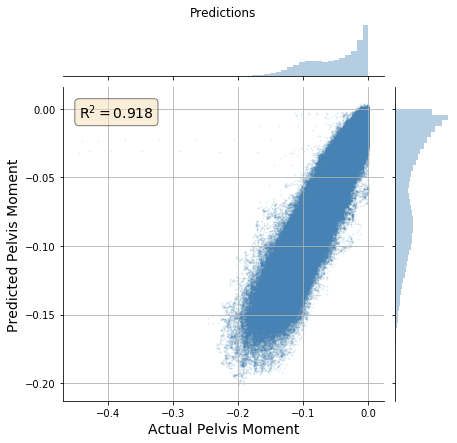

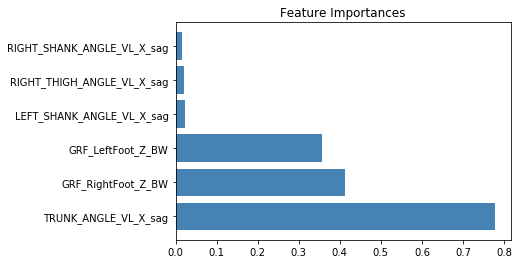

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**R2=0.909**

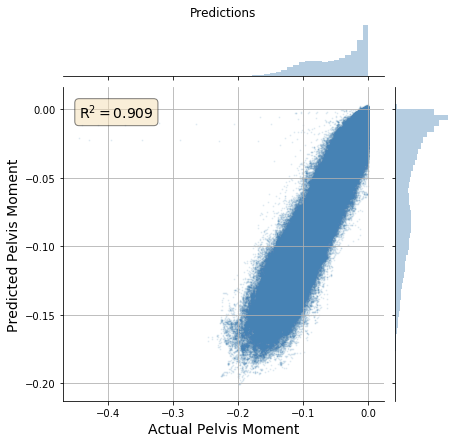

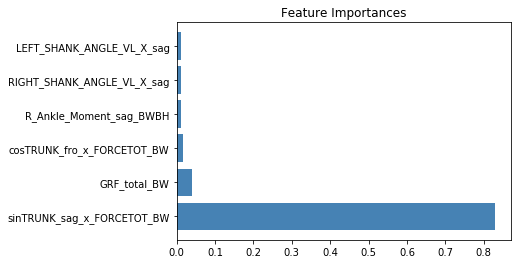

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**R2=0.791**

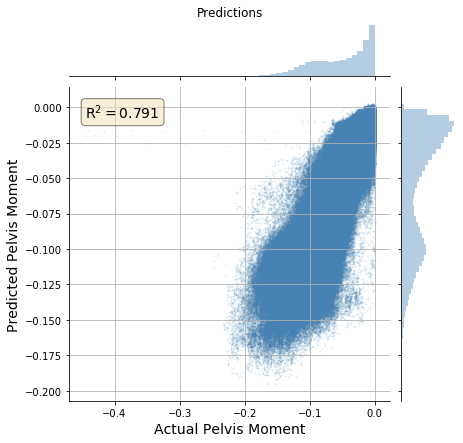

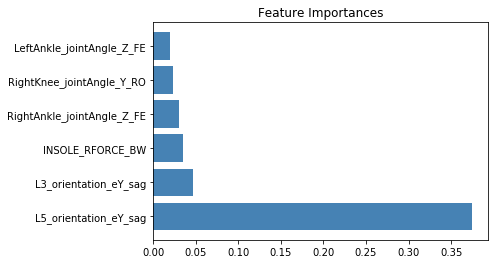

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**R2=0.755**

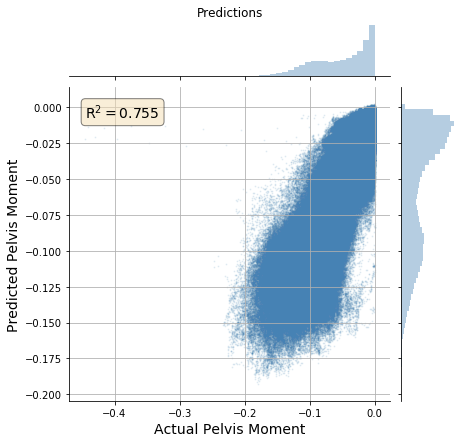

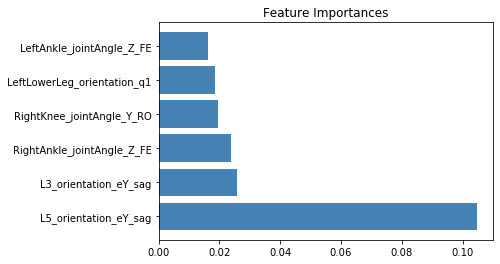

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**R2=0.061**

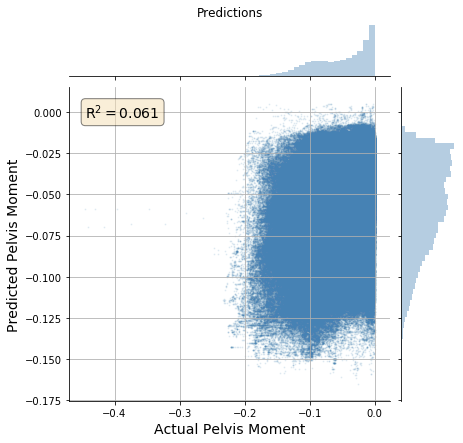

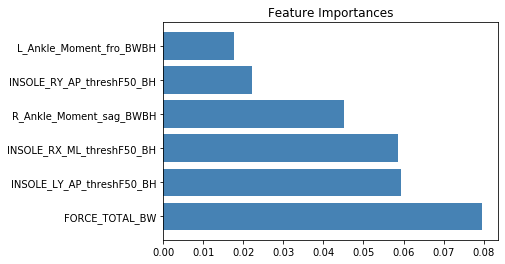

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**R2=0.781**

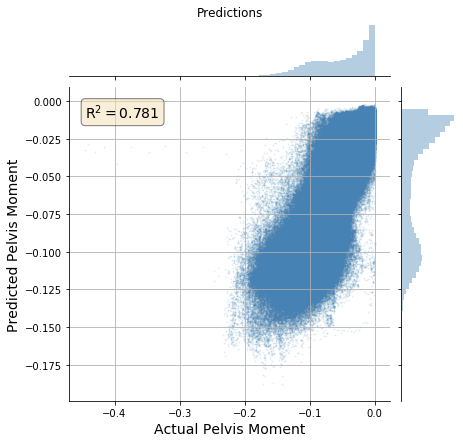

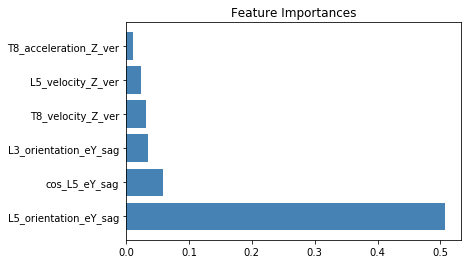

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**R2=0.719**

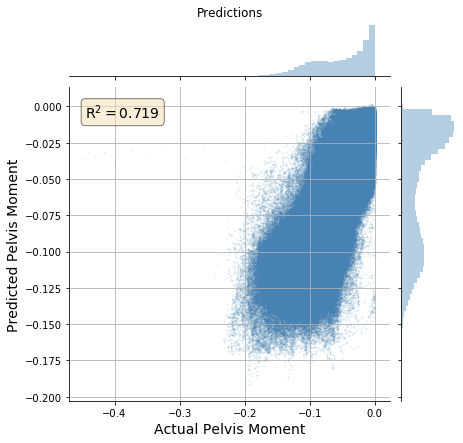

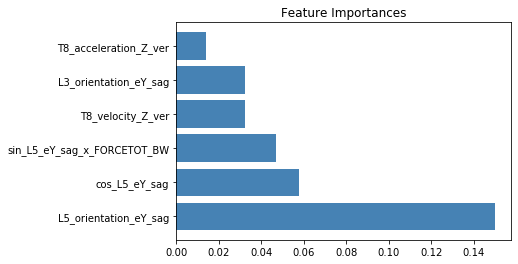

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**R2=0.732**

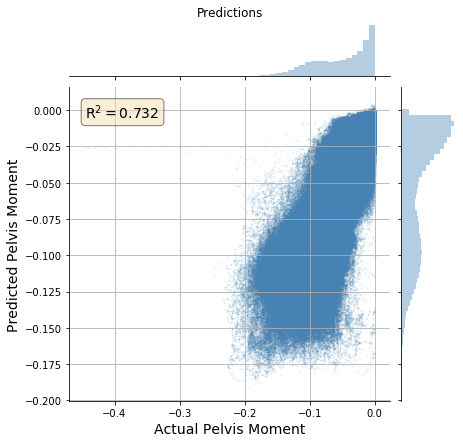

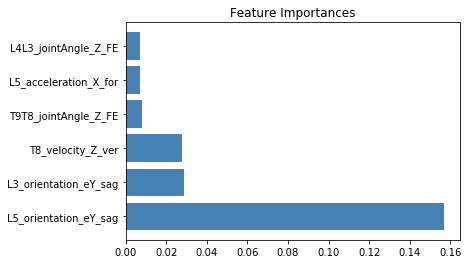

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 9: SW trunk angle + SW force  
**R2=0.868**

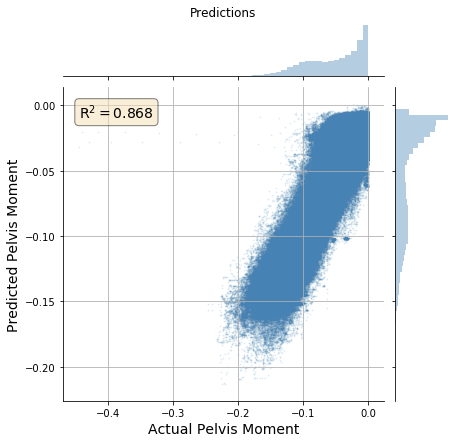

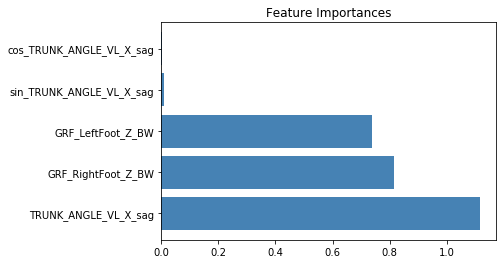

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 10: RW trunk angle + RW force  
**R2=0.678**

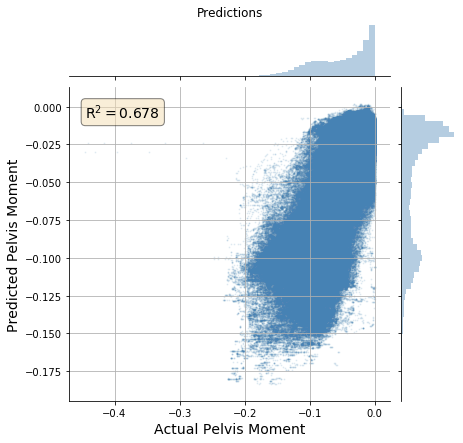

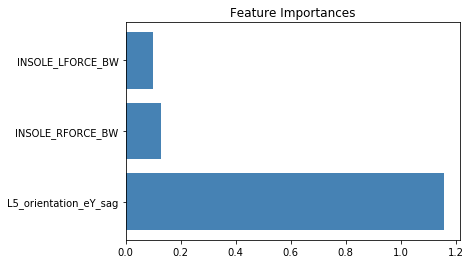

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 11: SW trunk angle + RW force  
**R2=0.681**

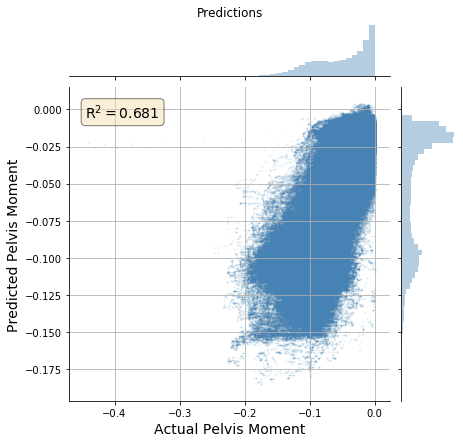

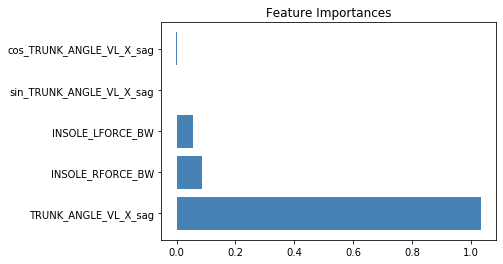

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 12: RW trunk angle + SW force  
**R2=0.868**

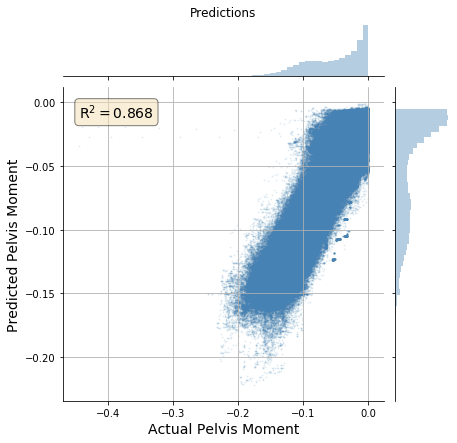

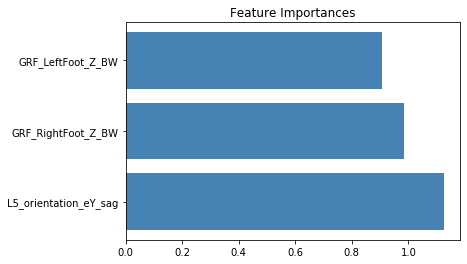

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 13: Simulated Wearable - Trunk Orientatoin Only  
**R2=0.703**

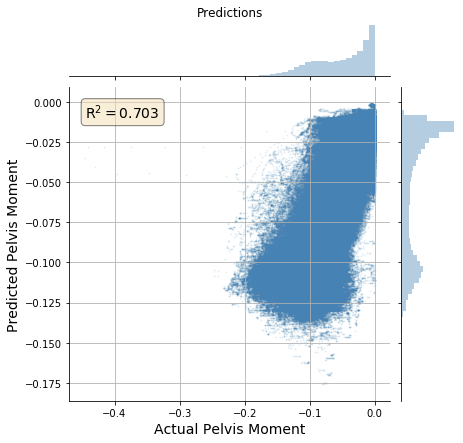

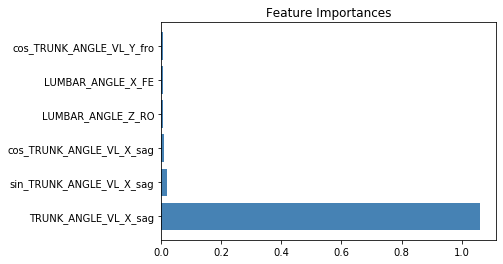

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 14: Simulated Wearable - Insole & Trunk Orientation  
**R2=0.881**

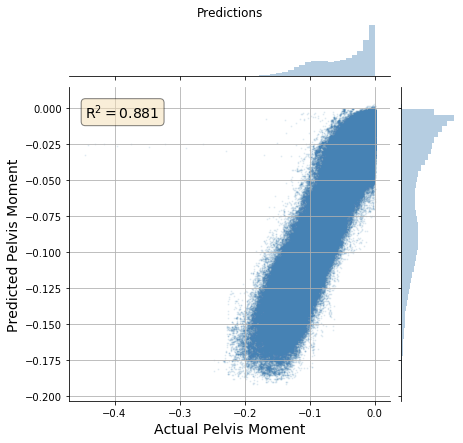

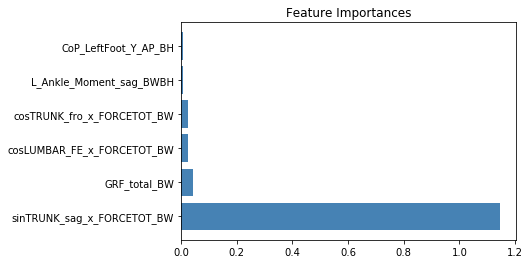

---
**Target**: TF_Pelvis_Moment_X_BWBH  
**Features**: Recipe 15: Simulated Wearable - Insole & Hip Angles & Trunk Orientation  
**R2=0.898**

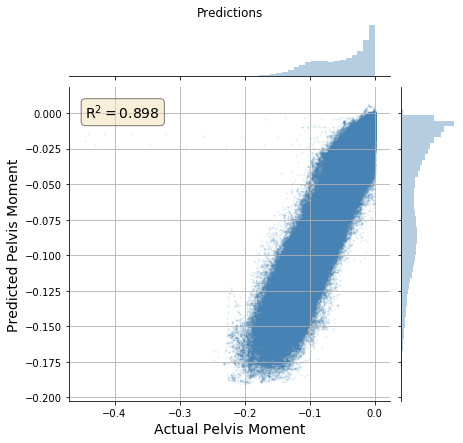

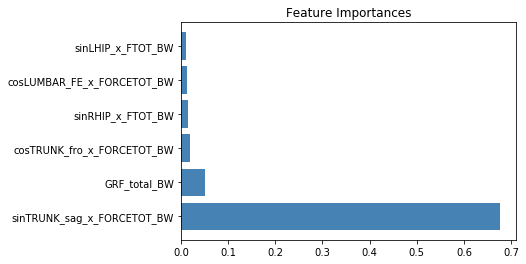

In [8]:
r2_scores_X, predictions_X = run_experiments("TF_Pelvis_Moment_X_BWBH", color="steelblue")

## Estimating TF_Pelvis_Moment_Y_BWBH


---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 1: Simulated Wearable - All Regular  
**R2=0.901**

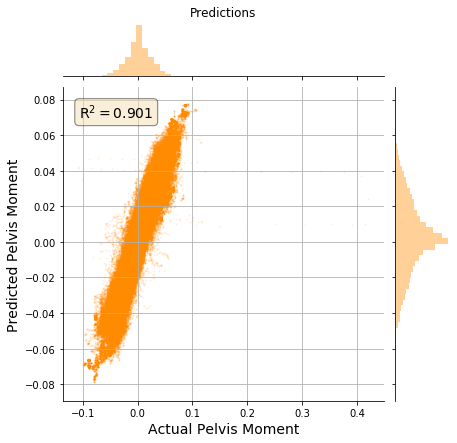

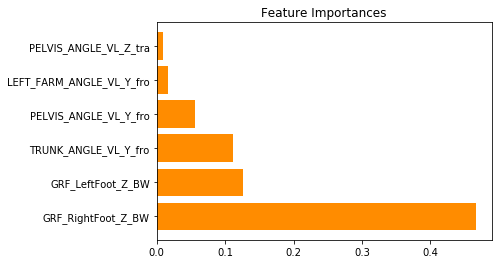

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 2: Simulated Wearable - All Regular & Exploratory  
**R2=0.901**

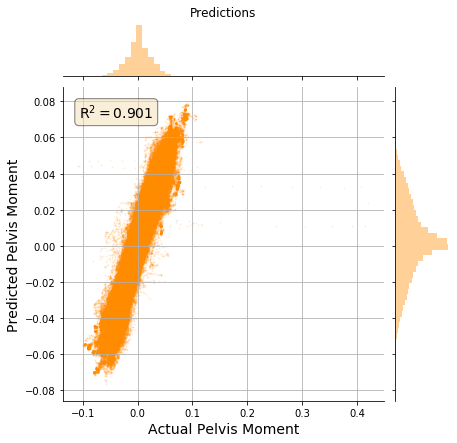

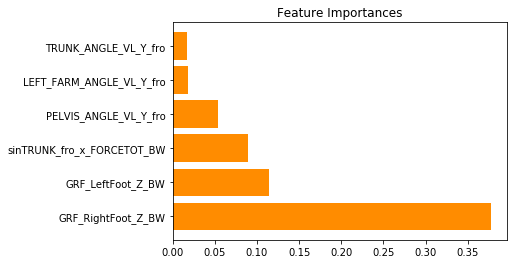

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 3: Real Wearable - All Regular  
**R2=0.738**

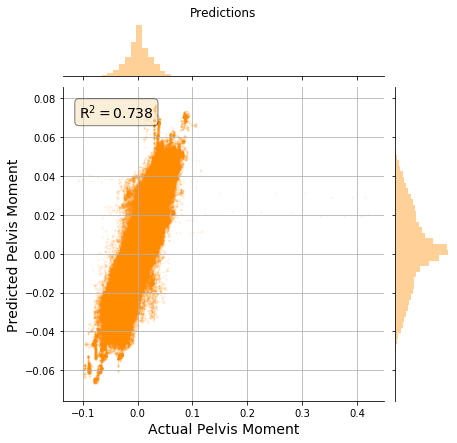

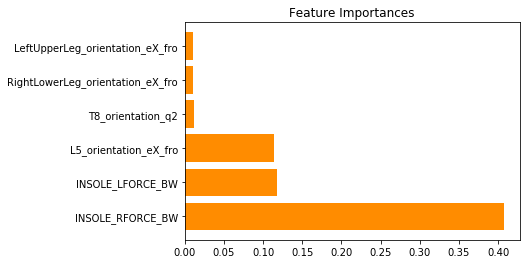

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 4: Real Wearable - All Regular & Exploratory  
**R2=0.736**

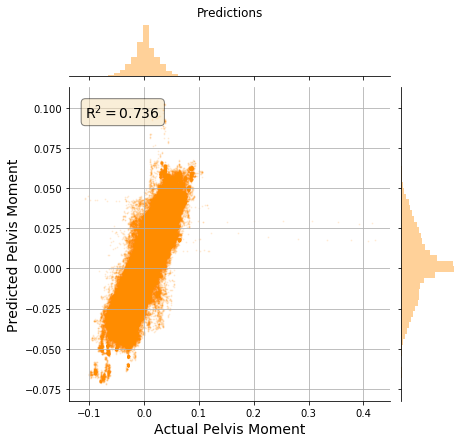

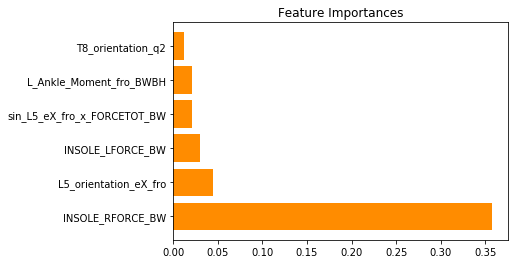

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 5: Real Wearable - Insole Only  
**R2=0.558**

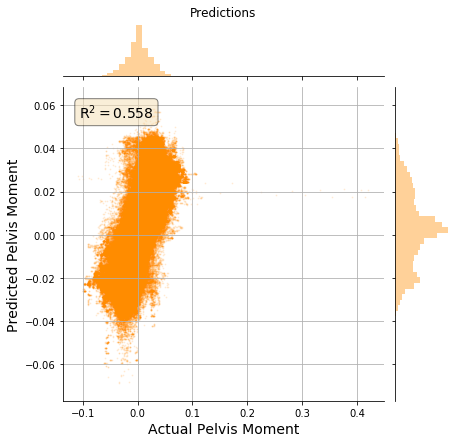

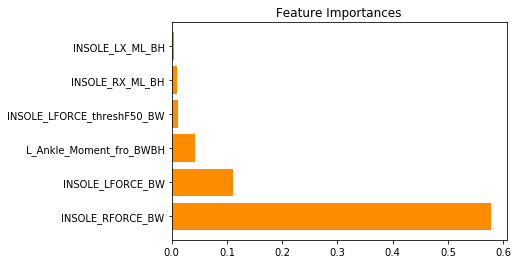

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 6: Real Wearable - Trunk Orientatoin Only  
**R2=0.590**

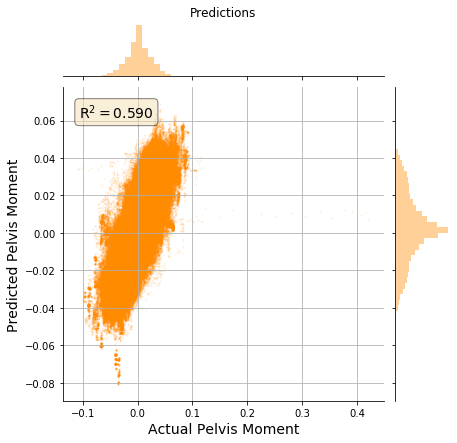

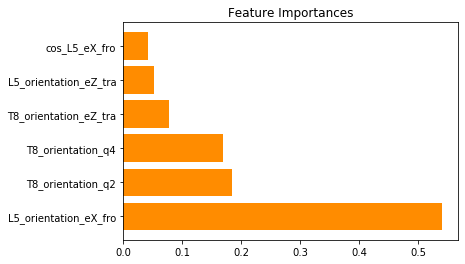

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 7: Real Wearable - Insole & Trunk Orientation  
**R2=0.688**

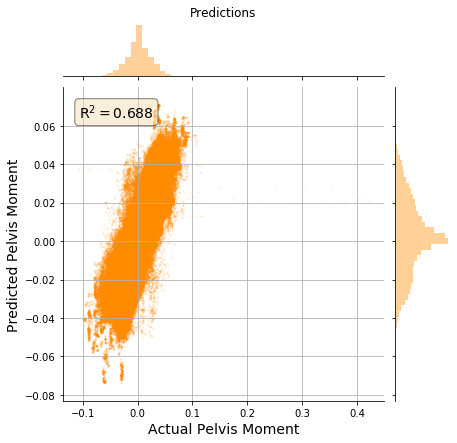

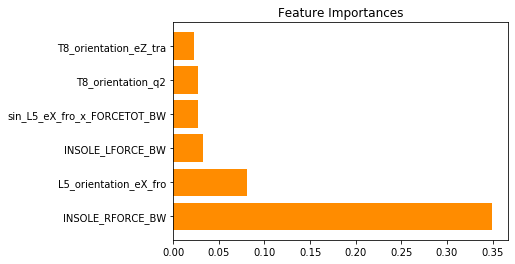

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation  
**R2=0.702**

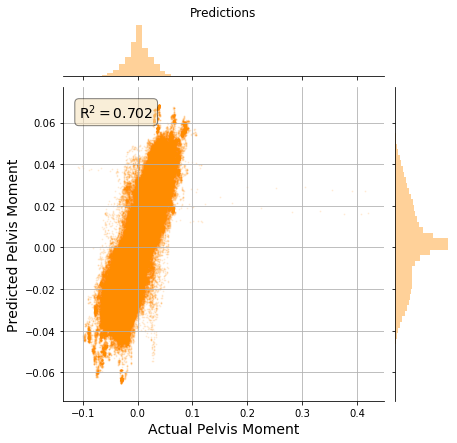

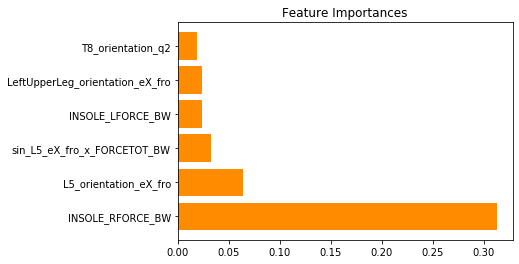

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 9: SW trunk angle + SW force  
**R2=0.623**

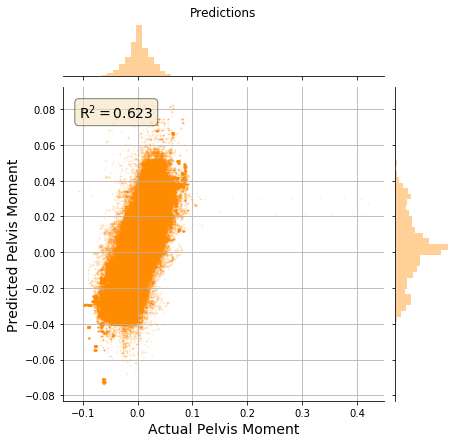

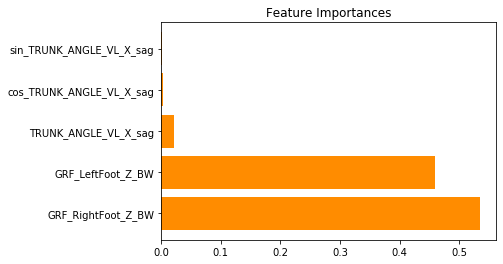

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 10: RW trunk angle + RW force  
**R2=0.558**

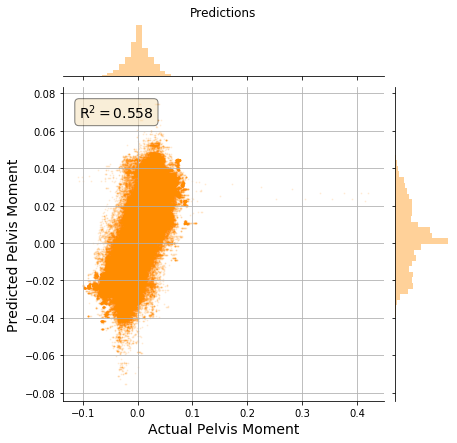

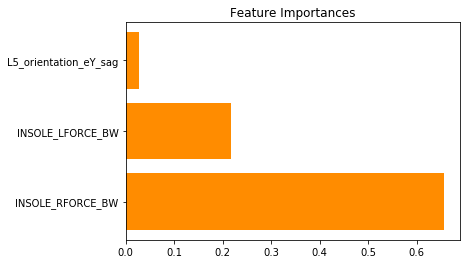

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 11: SW trunk angle + RW force  
**R2=0.553**

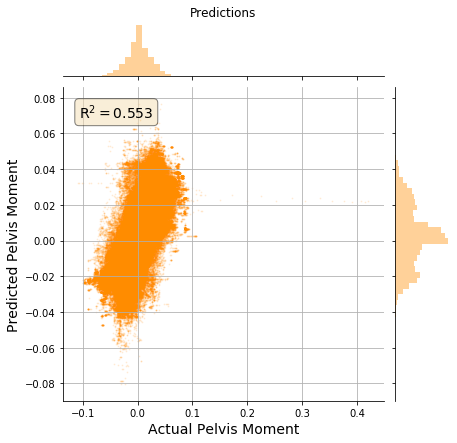

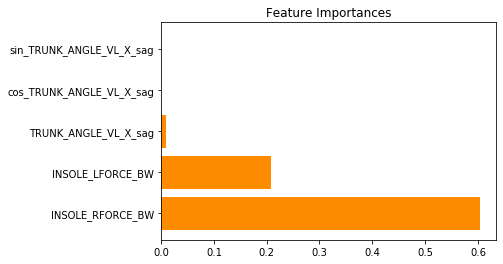

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 12: RW trunk angle + SW force  
**R2=0.630**

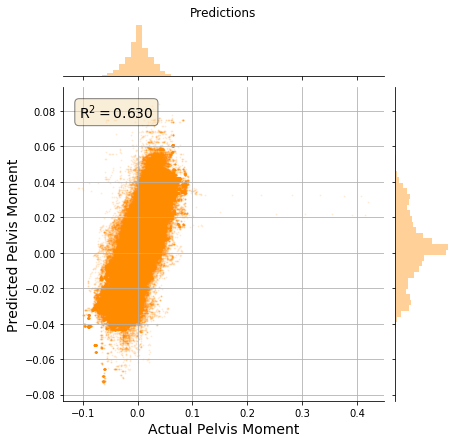

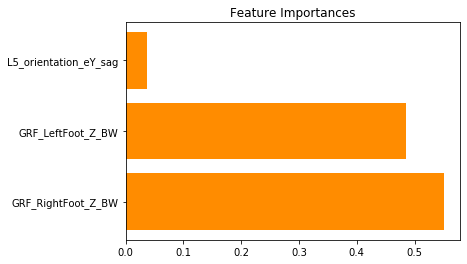

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 13: Simulated Wearable - Trunk Orientatoin Only  
**R2=0.629**

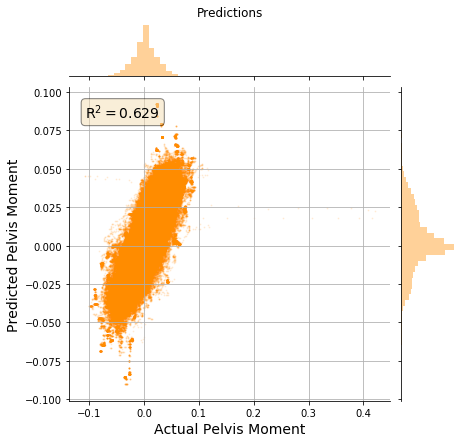

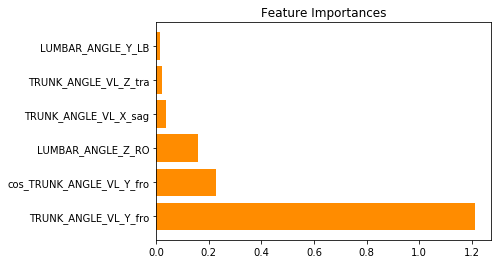

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 14: Simulated Wearable - Insole & Trunk Orientation  
**R2=0.834**

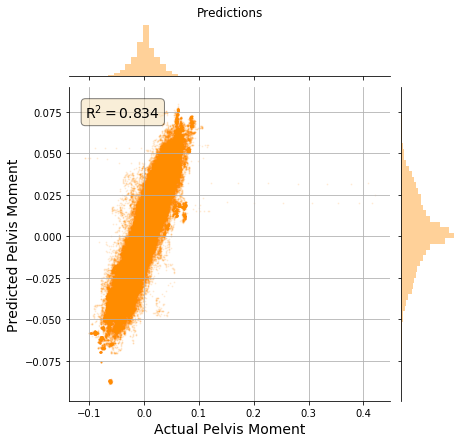

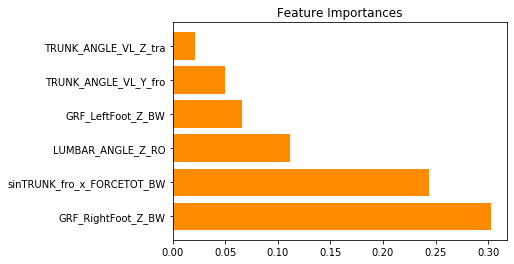

---
**Target**: TF_Pelvis_Moment_Y_BWBH  
**Features**: Recipe 15: Simulated Wearable - Insole & Hip Angles & Trunk Orientation  
**R2=0.867**

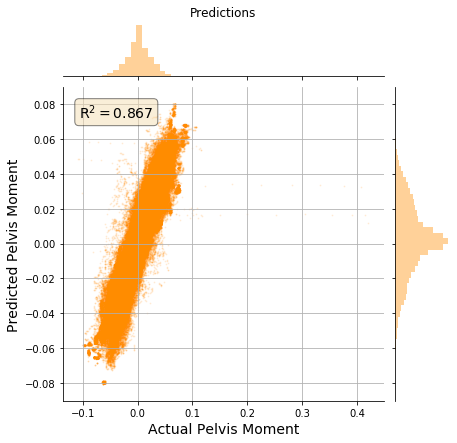

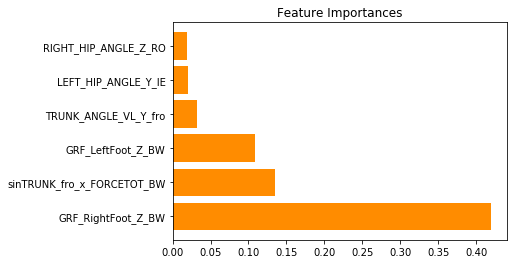

In [9]:
r2_scores_Y, predictions_Y = run_experiments("TF_Pelvis_Moment_Y_BWBH", color="darkorange")

## Saving results

In [10]:
with pd.ExcelWriter('CPAC10S_N7_09_15_20 - Results.xlsx') as writer:
    df_results = pd.DataFrame(
        {
            "TF_Pelvis_Moment_X_BWBH": r2_scores_X,
            "TF_Pelvis_Moment_Y_BWBH": r2_scores_Y
        }, 
        index=r2_scores_X.keys())
    df_results.to_excel(writer)

In [11]:
pred_df = df_orig[get_meta_names(df_orig) + ["TF_Pelvis_Moment_X_BWBH", "TF_Pelvis_Moment_Y_BWBH"]]

for feature_set in feature_sets:
    print(feature_set)
    kwargs = {
        feature_set[:8] + "_TF_Pelvis_Moment_X_BWBH": predictions_X[feature_set],
        feature_set[:8] + "_TF_Pelvis_Moment_Y_BWBH": predictions_Y[feature_set],
             }
    pred_df = pred_df.assign(**kwargs)
pred_df.to_csv(f"CPAC10S_N7_09_15_20 - Predictions.csv")


Recipe 1: Simulated Wearable - All Regular
Recipe 2: Simulated Wearable - All Regular & Exploratory
Recipe 3: Real Wearable - All Regular
Recipe 4: Real Wearable - All Regular & Exploratory
Recipe 5: Real Wearable - Insole Only
Recipe 6: Real Wearable - Trunk Orientatoin Only
Recipe 7: Real Wearable - Insole & Trunk Orientation
Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
Recipe 9: SW trunk angle + SW force
Recipe 10: RW trunk angle + RW force
Recipe 11: SW trunk angle + RW force
Recipe 12: RW trunk angle + SW force
Recipe 13: Simulated Wearable - Trunk Orientatoin Only
Recipe 14: Simulated Wearable - Insole & Trunk Orientation
Recipe 15: Simulated Wearable - Insole & Hip Angles & Trunk Orientation
